# Autoencoders on Fashion MNIST


Autoencoders are a type of neural network architecture used for unsupervised learning, particularly in the field of dimensionality reduction and feature learning. They consist of an encoder network that compresses the input data into a latent representation, and a decoder network that reconstructs the input data from this representation. Autoencoders are commonly used for tasks such as data compression, denoising, and anomaly detection.

In [1]:
import tensorflow as tf
tf.__version__

'2.17.0'

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras import layers, models, datasets, callbacks

<img src= "https://frenzy86.s3.eu-west-2.amazonaws.com/python/nlp/a1.3.png" width=800>


In [3]:
# Define class labels
class_labels = {
                0: "T-shirt/top",
                1: "Trouser",
                2: "Pullover",
                3: "Dress",
                4: "Coat",
                5: "Sandal",
                6: "Shirt",
                7: "Sneaker",
                8: "Bag",
                9: "Ankle boot"
                }

def display(images, n=10, size=(20, 3), cmap="gray_r", as_type="float32"):
    """
    Displays n random images from each one of the supplied arrays.
    """
    if images.max() > 1.0:
        images = images / 255.0
    elif images.min() < 0.0:
        images = (images + 1.0) / 2.0

    plt.figure(figsize=size)
    for i in range(n):
        plt.subplot(1, n, i + 1)
        plt.imshow(images[i].astype(as_type), cmap=cmap)
        plt.axis("off")
    plt.show()

def preprocess(imgs):
    """
    Normalize and reshape the images
    """
    imgs = imgs.astype("float32") / 255.0
    imgs = np.pad(imgs, ((0, 0), (2, 2), (2, 2)), constant_values=0.0)
    imgs = np.expand_dims(imgs, -1)
    return imgs

In [4]:
# Load the data
(X_train, y_train), (X_test, y_test) = datasets.fashion_mnist.load_data()
X_train = preprocess(X_train)
X_test = preprocess(X_test)

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [5]:
X_train.shape

(60000, 32, 32, 1)

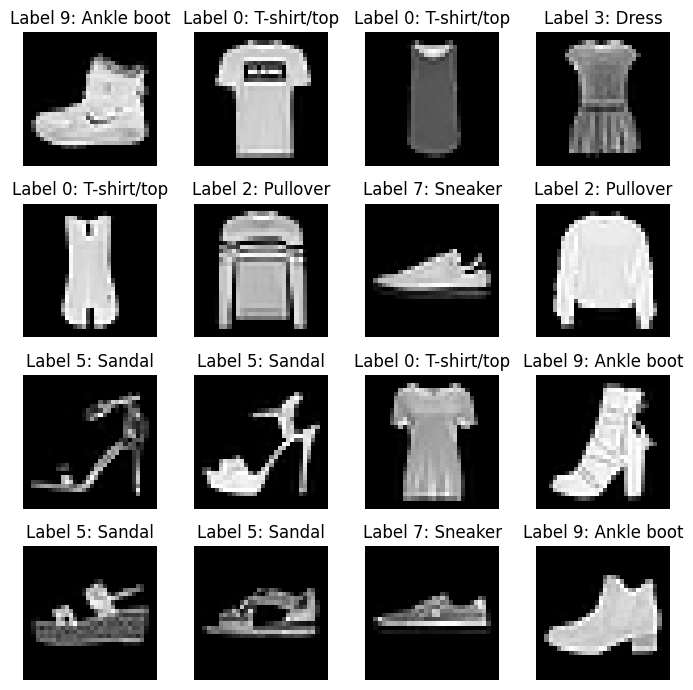

In [6]:
# Display the first 10 images in a 4x4 grid
plt.figure(figsize=(7, 7))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(X_train[i], cmap='gray')
    plt.title(f"Label {y_train[i]}: {class_labels[y_train[i]]}")
    plt.axis("off")

plt.tight_layout()
plt.show()

## 2. Build the autoencoder <a name="build"></a>

In [7]:
IMAGE_SIZE = 32
CHANNELS = 1
BATCH_SIZE = 100
BUFFER_SIZE = 1000
VALIDATION_SPLIT = 0.2
EMBEDDING_DIM = 2
EPOCHS = 5

In [8]:
from tensorflow.keras.layers import InputLayer,Conv2D,Flatten,Dense
from tensorflow.keras.models import Sequential

# Encoder
encoder = Sequential(name="encoder")

encoder.add(InputLayer(input_shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS)))
encoder.add(Conv2D(32, (3, 3), strides=2, activation="relu", padding="same"))
encoder.add(Conv2D(64, (3, 3), strides=2, activation="relu", padding="same"))
encoder.add(Conv2D(128, (3, 3), strides=2, activation="relu", padding="same"))
shape_before_flattening = encoder.output_shape[1:]  # the decoder will need this!
encoder.add(Flatten())
encoder.add(Dense(EMBEDDING_DIM, name="encoder_output"))
encoder.build(input_shape=(None, IMAGE_SIZE, IMAGE_SIZE, CHANNELS))  # Explicitly build the model
encoder.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 16, 16, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 8, 8, 64)            │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 4, 4, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ encoder_output (Dense)               │ (None, 2)                   │           4,098 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 96,770 (378.01 KB)

 Trainable params: 96,770 (378.01 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
# Set random seed for reproducibility
np.random.seed(667)
tf.random.set_seed(667)

<img src= "https://frenzy86.s3.eu-west-2.amazonaws.com/python/dcgan11.png" width=1000>

- Conv2D applies Convolutional operation on the input. On the contrary, Conv2DTranspose applies a Deconvolutional operation on the input.

- Conv2D is mainly used when you want to detect features, e.g., in the encoder part of an autoencoder model, and it may shrink your input shape.
Conversely, Conv2DTranspose is used for creating features, for example, in the decoder part of an autoencoder model for constructing an image. As you can see in the code below, it makes the input shape larger.

<img src= "https://frenzy86.s3.eu-west-2.amazonaws.com/python/az1.png" width=1000>

In [10]:
from tensorflow.keras.layers import InputLayer,Conv2D,Reshape,Dense,Conv2DTranspose
from tensorflow.keras.models import Sequential

# Decoder
decoder = Sequential(name="decoder")

decoder.add(InputLayer(input_shape=(EMBEDDING_DIM,)))
decoder.add(Dense(np.prod(shape_before_flattening)))
decoder.add(Reshape(shape_before_flattening))
decoder.add(Conv2DTranspose(128, (3, 3), strides=2, activation="relu", padding="same"))
decoder.add(Conv2DTranspose(64, (3, 3), strides=2, activation="relu", padding="same"))
decoder.add(Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same"))
decoder.add(Conv2D(CHANNELS, (3, 3), strides=1, activation="sigmoid", padding="same", name="decoder_output"))
decoder.build(input_shape=(None, EMBEDDING_DIM))  # Explicitly build the model
decoder.summary()


Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 2048)                │           6,144 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, 8, 8, 128)           │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (None, 16, 16, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_2 (Conv2DTranspose) │ (None, 32, 32, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder_output (Conv2D)              │ (None, 32, 32, 1)           │             289 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 246,273 (962.00 KB)

 Trainable params: 246,273 (962.00 KB)

 Non-trainable params: 0 (0.00 B)

In [11]:
# Autoencoder
autoencoder = Sequential(name="autoencoder")
autoencoder.add(encoder)
autoencoder.add(decoder)
autoencoder.build(input_shape=(None, IMAGE_SIZE, IMAGE_SIZE, CHANNELS))  # Explicitly build the model
autoencoder.summary()

Model: "autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ encoder (Sequential)                 │ (None, 2)                   │          96,770 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder (Sequential)                 │ (None, 32, 32, 1)           │         246,273 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 343,043 (1.31 MB)

 Trainable params: 343,043 (1.31 MB)

 Non-trainable params: 0 (0.00 B)

## 3. Train the autoencoder <a name="train"></a>

In [12]:
# Compile the autoencoder
autoencoder.compile(optimizer="adam",
                    loss="binary_crossentropy",#2spaces
                    )

In [13]:
model_checkpoint_callback = callbacks.ModelCheckpoint(
                                                    filepath="./checkpoint/*.keras",
                                                    save_weights_only=False,
                                                    save_freq="epoch",
                                                    monitor="loss",
                                                    mode="min",
                                                    save_best_only=True,
                                                    verbose=0,
                                                    )
#tensorboard_callback = callbacks.TensorBoard(log_dir="./logs")

In the context of training an autoencoder, it is common to use the same data for both input and target during training. This is because an autoencoder is trained to reconstruct its input at its output layer. By using the same data for input and target, the autoencoder learns to map the input data to itself, effectively learning a compressed representation of the input.

- X_train: Input data that you want the autoencoder to reconstruct.
- X_train (again): Target data, the same as the input, indicating what the autoencoder should reconstruct.

In [14]:
autoencoder.fit(X_train,
                X_train,
                epochs=EPOCHS,
                batch_size=BATCH_SIZE,
                shuffle=True,
                validation_data=(X_test, X_test),
                callbacks=[model_checkpoint_callback],
#               callbacks=[model_checkpoint_callback, tensorboard_callback],
                )

Epoch 1/5
600/600 ━━━━━━━━━━━━━━━━━━━━ 14s 10ms/step - loss: 0.3628 - val_loss: 0.2643
Epoch 2/5
600/600 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.2614 - val_loss: 0.2583
Epoch 3/5
600/600 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.2561 - val_loss: 0.2570
Epoch 4/5
600/600 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.2536 - val_loss: 0.2542
Epoch 5/5
600/600 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.2519 - val_loss: 0.2533


In [15]:
!mkdir models

In [16]:
# Save the final models
autoencoder.save("./models/autoencoder.keras")
encoder.save("./models/encoder.keras")
decoder.save("./models/decoder.keras")

## 4. Reconstruct using the autoencoder <a name="reconstruct"></a>

In [17]:
n_to_predict = 5000
example_images = X_test[:n_to_predict]
example_labels = y_test[:n_to_predict]

<img src= "https://frenzy86.s3.eu-west-2.amazonaws.com/python/nlp/a1.1.png" width=1000>

157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
Example real clothing items


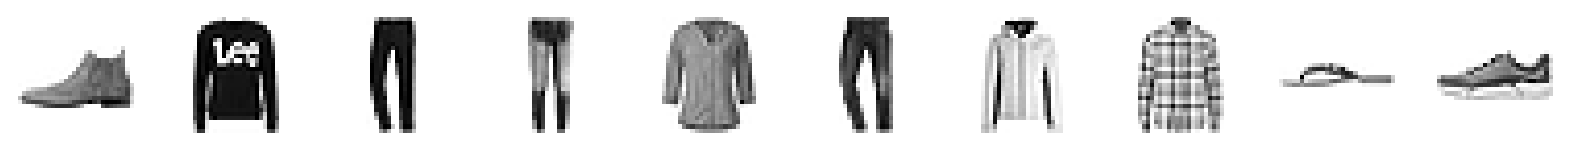

Reconstructions


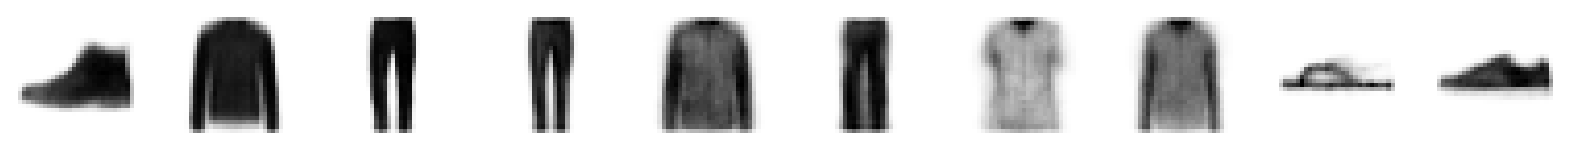

In [18]:
predictions = autoencoder.predict(example_images)

print("Example real clothing items")
display(example_images)
print("Reconstructions")
display(predictions)

## 5. Embed using the encoder <a name="encode"></a>

<img src= "https://frenzy86.s3.eu-west-2.amazonaws.com/python/nlp/a1.2.png" width=1000>

In [19]:
# Encode the example images
embeddings = encoder.predict(example_images)

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


In [20]:
# Some examples of the embeddings
print(embeddings[:10])

[[ -3.8896232   -1.0480705 ]
 [  3.2645452    1.4642069 ]
 [  6.787366   -14.899688  ]
 [  3.7048016  -11.34327   ]
 [  1.5199999    0.10350464]
 [  4.7628927   -7.7154107 ]
 [  1.3726398   -2.4730463 ]
 [  1.9152154   -0.6050464 ]
 [ -3.0348186   -7.168079  ]
 [ -4.172072    -4.9306393 ]]


In [21]:
import plotly.express as px
import numpy as np

figsize = 8
fig = px.scatter(
                x=embeddings[:, 0],
                y=embeddings[:, 1],
                opacity=0.5,
                color_discrete_sequence=['black'],  # Set color to black
                title='Encoded Points in 2D Space'
                )
fig.update_traces(marker=dict(size=6))  # Set marker size to 3
fig.update_layout(width=800)
fig.update_layout(height=800)
fig.show()

In [22]:
example_labels = y_test[:n_to_predict]

In [23]:
## Map the Classes number's to Clothing Type
def map_numerical_to_labels(numerical_array, labels_dict):
    return [labels_dict[num] for num in numerical_array]

mapped_labels = np.array(map_numerical_to_labels(example_labels, class_labels))
mapped_labels

array(['Ankle boot', 'Pullover', 'Trouser', ..., 'Ankle boot',
       'T-shirt/top', 'Sneaker'], dtype='<U11')

In [24]:
# Colour the embeddings by their label (clothing type - see table)
figsize = 12
grid_size = 15

# Create scatter plot for embeddings
scatter_fig = px.scatter(
                        x=embeddings[:, 0],
                        y=embeddings[:, 1],
                        color=mapped_labels,#example_labels,
                        opacity=0.8,
                        size_max=300,
                        labels={'color': 'Clothing Type'},
                        title='Colored - Embeddings'
                        )
# Set the width of the plot
scatter_fig.update_layout(width=800)
scatter_fig.update_layout(height=800)
scatter_fig.show()

## 6. Generate using the decoder <a name="decode"></a>

In [25]:
# Get the range of the existing embeddings
mins, maxs = np.min(embeddings, axis=0), np.max(embeddings, axis=0)

# Sample some points in the latent space
grid_width, grid_height = (6, 3)
sample = np.random.uniform(mins, maxs, size=(grid_width * grid_height, EMBEDDING_DIM))

In [26]:
# Decode the sampled points
reconstructions = decoder.predict(sample)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 496ms/step


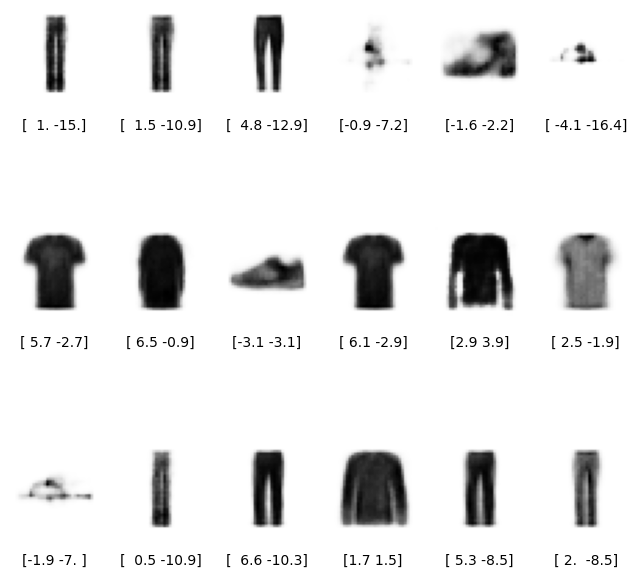

In [27]:
import plotly.express as px
import plotly.graph_objects as go
import numpy as np

# Assuming 'embeddings' and 'sample' are your data
figsize = 8

# Scatter plot for original embeddings
fig = px.scatter(
                x=embeddings[:, 0],
                y=embeddings[:, 1],
                opacity=0.5,
                color_discrete_sequence=['black'],  # Set color to black
                title='Original Embeddings'
                )
# Scatter plot for newly generated points in the latent space
fig.add_trace(px.scatter(
                        x=sample[:, 0],
                        y=sample[:, 1],
                        opacity=1,
                        size_max=40,
                        color_discrete_sequence=['#00B0F0'],  # Set color to blue
                        title='Generated Points in Latent Space'
                        ).data[0])

# Set the width of the plot
fig.update_layout(width=800)
fig.update_layout(height=800)

# Add text annotations for the numerical values on blue points
for i, point in enumerate(sample):
    fig.add_annotation(
        go.layout.Annotation(
            x=point[0],
            y=point[1],
            text=str(i+1),  # Assuming you want to display point index
            showarrow=False,
            font=dict(color='black', size=12),
            xshift=5,  # Adjust the text position
            yshift=5   # Adjust the text position
        )
    )

fig.show()

fig = plt.figure(figsize=(figsize, figsize))
for i in range(grid_width * grid_height):
    ax = fig.add_subplot(grid_height, grid_width, i + 1)
    ax.axis("off")
    ax.text(
        0.5,
        -0.35,
        str(np.round(sample[i, :], 1)),
        fontsize=10,
        ha="center",
        transform=ax.transAxes,
    )
    ax.imshow(reconstructions[i, :, :], cmap="Greys")

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step


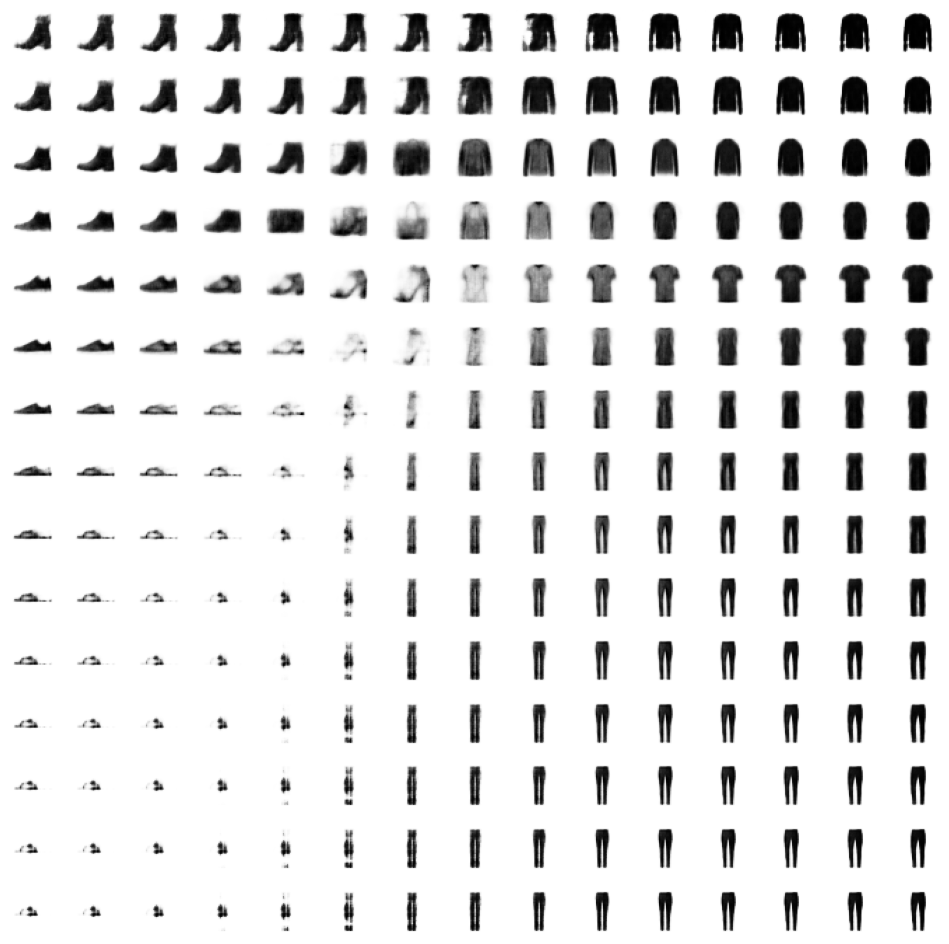

In [28]:
import plotly.express as px
import numpy as np

figsize = 12
grid_size = 15

# Create scatter plot for embeddings
scatter_fig = px.scatter(
                        x=embeddings[:, 0],
                        y=embeddings[:, 1],
                        color=mapped_labels,
                        opacity=0.8,
                        size_max=300,
                        labels={'color': 'Clothing Type'},
                        title='Colored - Embeddings'
                        )
# Set the width of the plot
scatter_fig.update_layout(width=800)
scatter_fig.update_layout(height=800)
scatter_fig.show()
################################################################################
x = np.linspace(min(embeddings[:, 0]), max(embeddings[:, 0]), grid_size)
y = np.linspace(max(embeddings[:, 1]), min(embeddings[:, 1]), grid_size)
xv, yv = np.meshgrid(x, y)
xv = xv.flatten()
yv = yv.flatten()
grid = np.array(list(zip(xv, yv)))

reconstructions = decoder.predict(grid)
# plt.scatter(grid[:, 0], grid[:, 1], c="black", alpha=1, s=10)
plt.show()

fig = plt.figure(figsize=(figsize, figsize))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i in range(grid_size**2):
    ax = fig.add_subplot(grid_size, grid_size, i + 1)
    ax.axis("off")
    ax.imshow(reconstructions[i, :, :], cmap="Greys")